# Variant effect prediction

In [1]:
import bioframe as bf
from datasets import load_dataset
from functools import reduce
from gpn.data import load_table
import numpy as np
import pandas as pd
from pathlib import Path
from math import sqrt
import matplotlib.pyplot as plt
from scipy.special import softmax
from scipy.stats import pearsonr, spearmanr, fisher_exact

import seaborn as sns
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, RocCurveDisplay, average_precision_score, PrecisionRecallDisplay
from tqdm import tqdm
tqdm.pandas()
import warnings
warnings.filterwarnings('ignore')

/accounts/projects/yss/gbenegas/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def plot_curve(V, results, curve, title, pos_label="Pathogenic", pos_prop=None, save_path=None):
    if curve == "ROC":
        plot_f = RocCurveDisplay
        metric = "AUROC"
        xlabel = 'False Positive Rate'
        ylabel = 'True Positive Rate'
        random_plot = lambda ax: ax.plot([0, 1], [0, 1], linestyle="--", color="gray")
    elif curve == "PR":
        plot_f = PrecisionRecallDisplay
        metric = "AUPRC"
        xlabel = 'Recall'
        ylabel = 'Precision'
        random_plot = lambda ax: ax.axhline(y=pos_prop, linestyle="--", color="gray")
    
    # note: latest sklearn has argument: plot_chance_level
    fig, ax = plt.subplots(figsize=(3,3))

    for m in results.Model.unique()[::-1]:
        AUC = results[results.Model==m].iloc[0][metric]
        plot_f.from_predictions(V.label==pos_label, -V[m], name=m, ax=ax, label=f"{m} (AUC={AUC:.3f})", color=palette[m])
        
    random_plot(ax)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    sns.despine()
    
    ax.legend();
    # get handles and labels
    handles, labels = ax.get_legend_handles_labels()
    # reverse the order
    handles, labels = handles[::-1], labels[::-1]
    # create the legend with the reversed order
    ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))

    plt.title(title);
    if save_path is not None:
        plt.savefig(plot_dir + save_path, bbox_inches="tight")
        

color_neg = sns.color_palette("Dark2")[0]
color_pos = sns.color_palette("Dark2")[1]
palette_label = {
    "gnomAD/\nCommon": color_neg,
    "ClinVar/\nPathogenic": color_pos,
    "COSMIC/\nFrequent": color_pos,
    "OMIM/\nPathogenic": color_pos,
    "gnomAD/\nRare": color_pos,
    
    "Common": color_neg,
    "Rare": color_pos,
}

def barplot(df, metric, title, pos_prop=None, save_path=None, figsize=(3,3)):
    plt.figure(figsize=figsize)
    g = sns.barplot(
        data=df.sort_values(metric, ascending=False),
        y="Model",
        x=metric,
        palette=palette,
    )
    sns.despine();
    plt.title(title, fontsize=11);
    baseline = 0.5 if metric == "AUROC" else pos_prop
    g.set(xlim=baseline)
    plt.ylabel("");

    for bar in g.patches:
        g.text(
            bar.get_width(),  # X position, here at the end of the bar
            bar.get_y() + bar.get_height()/2,  # Y position, in the middle of the bar
            f'{bar.get_width():.3f}',  # Text to be displayed, formatted to 3 decimal places
            va='center'  # Vertical alignment
        )

    if save_path is not None:
        plt.savefig(plot_dir + save_path, bbox_inches="tight")

def histplot_label(V, save_path=None, **kwargs):
    V["Label"] = V.source + "/\n" + V.label
    plt.figure(figsize=(3,3))
    g = sns.histplot(
        data=V,
        x="GPN-MSA",
        hue="Label",
        bins=25,
        stat="density",
        common_norm=False,
        common_bins=True,
        palette=palette_label,
        **kwargs,
    )
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    if save_path is not None:
        plt.savefig(plot_dir + save_path, bbox_inches="tight")
        
        
def ecdfplot_label(V, save_path=None, **kwargs):
    plt.figure(figsize=(3,3))
    sns.ecdfplot(
        data=V,
        x="GPN-MSA",
        hue="label",
        palette=palette_label,
        **kwargs,
    )
    if save_path is not None:
        plt.savefig(plot_dir + save_path, bbox_inches="tight")

In [3]:
plot_dir = "../../results/plots/"

In [4]:
palette = {
    "GPN-MSA": "C0",
    "CADD": "C1",
    "phyloP": "C2",
    "ESM-1b": "C3",
    "NT": "C4",
    "SpliceAI": "C5",
    "Enformer": "C6",
    "HyenaDNA": "C9",
    
    "phyloP-100-vertebrates": "C2",
    "phyloP-241-mammals": "C7",
    "phastCons-100-vertebrates": "C8",
    
    "NT-500m-human-ref": "gray",
    "NT-500m-1000g": "gray",
    "NT-2.5b-1000g": "gray",
    "NT-2.5b-multi-species": "C4",
    
    r"Enformer ($L^1$)": "C7",
    r"Enformer ($L^2$)": "C6",
    r"Enformer ($L^\infty$)": "C8",
    
    "GPN-MSA + Enformer": "black",
    "GPN-MSA (Emb + LLR)": "black",
    
    "PrimateAI-3D": "black",
}

In [5]:
core_models = [
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True",
    "CADD.RawScore",
    "phyloP",
    "phyloP-Zoonomia",
    "phastCons",
    "InstaDeepAI/nucleotide-transformer-2.5b-multi-species",
]

hyenadna_models = [
    #'LongSafari/hyenadna-tiny-1k-seqlen-hf',
    #'LongSafari/hyenadna-small-32k-seqlen-hf',
    #'LongSafari/hyenadna-medium-160k-seqlen-hf',
    #'LongSafari/hyenadna-medium-450k-seqlen-hf',
    'LongSafari/hyenadna-large-1m-seqlen-hf',    
]

ablation_models = pd.read_csv("../../models.txt", header=None).values.ravel().tolist()[1:]
#ablation_models = ["msa_multiz100way/89"]
ablation_models = []

model_renaming = { 
    # GPN-MSA
    #"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True": "GPN-MSA",

    "InstaDeepAI/nucleotide-transformer-2.5b-multi-species": "NT",
    
    # HyenaDNA models
    'LongSafari/hyenadna-large-1m-seqlen-hf': "HyenaDNA",
    
    # Other models
    "CADD.RawScore": "CADD",
    #"phyloP": "phyloP-100-vertebrates",
    "phastCons": "phastCons-100-vertebrates",
    "phyloP-Zoonomia": "phyloP-241-mammals",
}

def gather_unique_values(d):
    unique_values = []
    seen = set()

    def gather_values(nested_dict):
        for value in nested_dict.values():
            if isinstance(value, dict):
                gather_values(value)
            elif isinstance(value, list):
                for item in value:
                    if item not in seen:
                        unique_values.append(item)
                        seen.add(item)

    gather_values(d)

    return unique_values

def apply_to_values(d, f):
    for key, value in d.items():
        if isinstance(value, dict):
            apply_to_values(value, f)
        elif isinstance(value, list):
            d[key] = [f(x) for x in value]
        else:
            d[key] = f(value)

dataset_models = {
    "ClinVar": core_models + ["ESM-1b"], # + hyenadna_models  + ablation_models, #+ ["PrimateAI-3D"],

    "COSMIC": core_models + ["ESM-1b"], #+ nt_models[-1:]+ ablation_models, #+ ["PrimateAI-3D"],

    "OMIM": {
        "all": core_models + ablation_models,
        "Promoter": core_models,
        "Enhancer": core_models,
        "5' UTR": core_models,
        "3' UTR": core_models,
        "ncRNA": core_models,
    },
    
    "gnomAD": {
        "all": core_models, # + ablation_models,
        
        "missense": core_models + ["ESM-1b"], # + nt_models[-1:], # + ["PrimateAI-3D"],
        
        "synonymous": core_models, # + nt_models[-1:],
        "5_prime_UTR": core_models, # + nt_models[-1:],
        "3_prime_UTR": core_models, # + nt_models[-1:],
        "upstream_gene": core_models,
        "downstream_gene": core_models,
        
        "intron": core_models  + ["SpliceAI"],
        
        "intergenic": core_models,
        "non_coding_transcript_exon": core_models,
    },
    
    "gnomAD_Enformer": {
        "upstream_gene": core_models + ["Enformer_l1", "Enformer_l2", "Enformer_linf"],
        "intergenic": core_models + ["Enformer_l1", "Enformer_l2", "Enformer_linf"],
    },
}
models = gather_unique_values(dataset_models)

In [6]:
dataset_path = "results/clinvar/merged"
V_clinvar = load_dataset("../../" + dataset_path, split="test").to_pandas()
d = Path(f"../../results/preds/{dataset_path}")
for m in tqdm(dataset_models["ClinVar"]):
    model_name = model_renaming.get(m, m)
    model_path = d / f"{m}.parquet"
    V_clinvar[model_name] = pd.read_parquet(model_path)["score"].values
V_clinvar

100%|██████████| 7/7 [00:00<00:00, 10.75it/s]


,chrom,pos,ref,alt,label,id,review_status,consequence,AC,AN,AF,MAF,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True,CADD,phyloP,phyloP-241-mammals,phastCons-100-vertebrates,NT,ESM-1b
0,1,69511,A,G,Common,None,None,missense,70482.0,83312.0,0.846001,0.153999,1.493164,-0.112916,0.684,-3.290,-0.000,-1.597534,NaN
1,1,953279,T,C,Common,None,None,missense,142160.0,152178.0,0.934169,0.065831,2.578125,-0.266107,-0.037,-1.270,-0.009,-0.583755,-2.880
2,1,973858,G,C,Common,None,None,missense,101892.0,151984.0,0.670413,0.329587,1.562500,-0.787153,0.431,-0.835,-0.000,1.605270,-2.538
3,1,973929,T,C,Common,None,None,missense,32685.0,151974.0,0.215070,0.215070,-1.328125,-0.818047,-0.076,0.539,-0.001,0.537186,-3.377
4,1,976215,A,G,Pathogenic,1320032,no_assertion_criteria_provided,missense_variant,NaN,NaN,NaN,NaN,-2.527344,-1.476529,-0.054,0.421,-0.000,-0.049149,-5.335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40975,Y,2787426,C,G,Pathogenic,9739,"criteria_provided,_single_submitter",missense_variant,NaN,NaN,NaN,NaN,-6.515625,-2.215825,-5.679,-5.114,-1.000,0.021103,-9.000
40976,Y,2787515,C,A,Pathogenic,492908,no_assertion_criteria_provided,missense_variant,NaN,NaN,NaN,NaN,-0.703613,-1.614399,0.091,-0.120,-0.000,-2.884521,-4.780
40977,Y,2787551,C,T,Pathogenic,9754,no_assertion_criteria_provided,missense_variant,NaN,NaN,NaN,NaN,-0.416016,-0.541464,-0.675,-0.120,-0.989,0.071259,-4.299
40978,Y,7063898,A,T,Pathogenic,625467,no_assertion_criteria_provided,missense_variant,NaN,NaN,NaN,NaN,-7.085938,-3.594089,-6.040,-5.484,-1.000,-0.009460,-14.271


In [7]:
dataset_path = "results/cosmic/merged"
V_cosmic = load_dataset("../../" + dataset_path, split="test").to_pandas()
d = Path(f"../../results/preds/{dataset_path}")
for m in tqdm(dataset_models["COSMIC"]):
    model_name = model_renaming.get(m, m)
    model_path = d / f"{m}.parquet"
    V_cosmic[model_name] = pd.read_parquet(model_path)["score"].values
V_cosmic

100%|██████████| 7/7 [00:00<00:00, 47.63it/s]


,chrom,pos,ref,alt,GENOMIC_MUTATION_ID,consequence,n_samples,total_samples,freq,label,...,AN,AF,MAF,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True,CADD,phyloP,phyloP-241-mammals,phastCons-100-vertebrates,NT,ESM-1b
0,1,69511,A,G,None,missense,NaN,NaN,NaN,Common,...,83312.0,0.846001,0.153999,1.493164,-0.112916,0.684,-3.290,-0.000,-1.597534,NaN
1,1,953279,T,C,None,missense,NaN,NaN,NaN,Common,...,152178.0,0.934169,0.065831,2.578125,-0.266107,-0.037,-1.270,-0.009,-0.583755,-2.880
2,1,973858,G,C,None,missense,NaN,NaN,NaN,Common,...,151984.0,0.670413,0.329587,1.562500,-0.787153,0.431,-0.835,-0.000,1.605270,-2.538
3,1,973929,T,C,None,missense,NaN,NaN,NaN,Common,...,151974.0,0.215070,0.215070,-1.328125,-0.818047,-0.076,0.539,-0.001,0.537186,-3.377
4,1,976215,A,G,None,missense,NaN,NaN,NaN,Common,...,152134.0,0.714705,0.285295,-2.527344,-1.476529,-0.054,0.421,-0.000,-0.049149,-5.335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18910,X,156022062,G,A,None,missense,NaN,NaN,NaN,Common,...,107906.0,0.138343,0.138343,-6.750000,-1.151562,-6.803,-5.976,-1.000,-1.477493,NaN
18911,X,156022092,C,T,None,missense,NaN,NaN,NaN,Common,...,107374.0,0.063535,0.063535,-5.042969,-1.114651,-2.109,-4.822,-0.960,0.699081,NaN
18912,X,156023118,G,T,None,missense,NaN,NaN,NaN,Common,...,110532.0,0.077226,0.077226,-5.953125,-1.176230,-4.017,-5.933,-1.000,0.612045,NaN
18913,X,156024251,A,C,None,missense,NaN,NaN,NaN,Common,...,108508.0,0.074474,0.074474,-3.390625,-1.868737,-6.335,-0.287,-1.000,-0.369003,NaN


In [8]:
dataset_path = "results/omim/merged"
V_omim = load_dataset("../../" + dataset_path, split="test").to_pandas()
d = Path(f"../../results/preds/{dataset_path}")
for m in tqdm(gather_unique_values(dataset_models["OMIM"])):
    model_name = model_renaming.get(m, m)
    model_path = d / f"{m}.parquet"
    V_omim[model_name] = pd.read_parquet(model_path)["score"].values
V_omim

100%|██████████| 6/6 [00:00<00:00, 14.39it/s]


,chrom,pos,ref,alt,label,consequence,OMIM,Gene,PMID,AC,AN,AF,MAF,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True,CADD,phyloP,phyloP-241-mammals,phastCons-100-vertebrates,NT
0,1,14464,A,T,Common,ncRNA,None,None,NaN,26287.0,133502.0,0.196903,0.196903,0.895020,0.339809,1.705,-0.992,-0.000,-0.155609
1,1,51479,T,A,Common,Promoter,None,None,NaN,28476.0,111172.0,0.256144,0.256144,-1.281250,-0.208313,0.212,-0.604,-0.001,-2.320801
2,1,51803,T,C,Common,Promoter,None,None,NaN,42169.0,110124.0,0.382923,0.382923,-1.322266,-0.448316,-0.393,-0.107,-0.091,-3.083298
3,1,51928,G,A,Common,Promoter,None,None,NaN,17118.0,81676.0,0.209584,0.209584,1.206055,-0.244843,-0.176,0.060,-0.001,0.418243
4,1,52058,G,C,Common,Promoter,None,None,NaN,19797.0,82322.0,0.240482,0.240482,-1.276367,0.073860,0.238,-0.137,-0.000,-0.945038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215298,Y,19087904,G,A,Common,Enhancer,None,None,NaN,1990.0,33508.0,0.059389,0.059389,0.104004,-0.182527,0.650,6.269,-0.120,0.091644
215299,Y,19568371,G,C,Common,ncRNA,None,None,NaN,14145.0,32811.0,0.431105,0.431105,1.908203,0.304264,1.864,-0.091,-0.000,-0.612640
215300,Y,19755427,T,C,Common,ncRNA,None,None,NaN,7352.0,32992.0,0.222842,0.222842,0.358887,-0.265817,2.187,1.591,-0.152,0.262604
215301,Y,22308393,T,G,Common,Promoter,None,None,NaN,1900.0,33108.0,0.057388,0.057388,-0.581055,-0.088011,1.784,-0.095,-0.000,-2.304901


In [9]:
dataset_path = "results/gnomad/merged/subsampled"
V_gnomad = load_dataset("../../" + dataset_path, split="test").to_pandas()
d = Path(f"../../results/preds/{dataset_path}")
for m in tqdm(gather_unique_values(dataset_models["gnomAD"])):
    model_name = model_renaming.get(m, m)
    model_path = d / f"{m}.parquet"
    V_gnomad[model_name] = pd.read_parquet(model_path)["score"].values
V_gnomad

100%|██████████| 8/8 [00:01<00:00,  4.91it/s]


,chrom,pos,ref,alt,AC,AN,AF,consequence,MAF,label,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True,CADD,phyloP,phyloP-241-mammals,phastCons-100-vertebrates,NT,ESM-1b,SpliceAI
0,1,14464,A,T,26287,133502,0.196903,non_coding_transcript_exon,0.196903,Common,0.895020,0.339809,1.705,-0.992,-0.000,-0.155609,NaN,NaN
1,1,51479,T,A,28476,111172,0.256144,upstream_gene,0.256144,Common,-1.281250,-0.208313,0.212,-0.604,-0.001,-2.320801,NaN,NaN
2,1,51803,T,C,42169,110124,0.382923,upstream_gene,0.382923,Common,-1.322266,-0.448316,-0.393,-0.107,-0.091,-3.083298,NaN,NaN
3,1,51928,G,A,17118,81676,0.209584,upstream_gene,0.209584,Common,1.206055,-0.244843,-0.176,0.060,-0.001,0.418243,NaN,NaN
4,1,52058,G,C,19797,82322,0.240482,upstream_gene,0.240482,Common,-1.276367,0.073860,0.238,-0.137,-0.000,-0.945038,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
705189,Y,20724947,A,G,1,33489,0.000030,downstream_gene,0.000030,Rare,-0.639160,-0.482205,-0.163,-0.095,-0.144,-0.901505,NaN,NaN
705190,Y,20725077,C,T,1,33568,0.000030,downstream_gene,0.000030,Rare,0.313477,-0.196757,-0.145,-0.120,-0.044,-2.924332,NaN,NaN
705191,Y,22305040,A,G,2906,33476,0.086809,downstream_gene,0.086809,Common,-1.853516,-0.267497,-0.257,-0.095,-0.002,-3.399231,NaN,NaN
705192,Y,22308393,T,G,1900,33108,0.057388,upstream_gene,0.057388,Common,-0.581055,-0.088011,1.784,-0.095,-0.000,-2.305817,NaN,NaN


In [10]:
dataset_path = "results/variants_enformer/"
V_enformer = pd.read_parquet("../../" + dataset_path + "test.parquet")
d = Path(f"../../results/preds/{dataset_path}")
for m in tqdm(gather_unique_values(dataset_models["gnomAD_Enformer"])):
    model_name = model_renaming.get(m, m)
    model_path = d / f"{m}.parquet"
    V_enformer[model_name] = pd.read_parquet(model_path)["score"].values
V_enformer

100%|██████████| 9/9 [00:00<00:00, 21.68it/s]


,chrom,pos,ref,alt,AC,AN,AF,consequence,label,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True,CADD,phyloP,phyloP-241-mammals,phastCons-100-vertebrates,NT,Enformer_l1,Enformer_l2,Enformer_linf
0,1,51479,T,A,28476,111172,0.256144,upstream_gene,Common,-1.281250,-0.208313,0.212,-0.604,-0.001,-2.320801,-2.703125,-0.061646,-0.008446
1,1,52238,T,G,100964,111364,0.906613,upstream_gene,Common,1.343750,0.048540,1.025,-0.078,-0.000,1.140945,-1.050781,-0.019714,-0.001596
2,1,56931,C,A,826,115376,0.007159,upstream_gene,Low-frequency,-1.348633,-0.172252,0.144,0.885,-0.000,0.125031,-4.667969,-0.087036,-0.006935
3,1,57095,T,C,676,131342,0.005147,upstream_gene,Low-frequency,-1.473633,-0.507170,0.094,0.004,-0.000,0.036224,-3.835938,-0.071838,-0.007751
4,1,64649,A,C,2523,140200,0.017996,upstream_gene,Low-frequency,-2.369141,-0.241779,-0.034,-0.107,-0.001,-5.811966,-1.554688,-0.033447,-0.004086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,22,50756633,A,C,17240,149152,0.115587,upstream_gene,Common,0.242676,-0.231283,NaN,1.701,NaN,5.811798,-3.644531,-0.090027,-0.022980
199996,22,50756655,G,C,1866,151130,0.012347,upstream_gene,Low-frequency,0.104492,-0.078518,NaN,1.665,NaN,3.985565,-1.497070,-0.035858,-0.005539
199997,22,50756699,T,C,21450,147826,0.145103,upstream_gene,Common,0.179688,-0.334398,NaN,-0.100,NaN,-5.152969,-1.245117,-0.028641,-0.005150
199998,22,50756702,G,A,141290,151162,0.934693,upstream_gene,Common,1.632812,-0.186303,NaN,1.840,NaN,6.194687,-1.534180,-0.046478,-0.012238


In [11]:
apply_to_values(dataset_models, lambda m: model_renaming.get(m, m))

## ClinVar pathogenic vs. gnomAD common (missense)

In [12]:
V_clinvar.dropna(subset=dataset_models["ClinVar"], inplace=True)
V_clinvar.label.value_counts()

label
Pathogenic    21275
Common        15404
Name: count, dtype: int64

In [13]:
rows = []
for m in tqdm(dataset_models["ClinVar"]):
    y_true = V_clinvar.label=="Pathogenic"
    y_score = -V_clinvar[m]
    AUROC = roc_auc_score(y_true, y_score)
    AUPRC = average_precision_score(y_true, y_score)
    rows.append([m, AUROC, AUPRC])
results_clinvar = pd.DataFrame(rows, columns=["Model", "AUROC", "AUPRC"]).sort_values("AUROC", ascending=False)
results_clinvar

100%|██████████| 7/7 [00:00<00:00, 26.96it/s]


,Model,AUROC,AUPRC
0,multiz100way/89/128/64/True/defined.phastCons....,0.968483,0.975968
1,CADD,0.962933,0.968877
6,ESM-1b,0.943733,0.962538
2,phyloP,0.923232,0.941865
3,phyloP-241-mammals,0.904541,0.916901
4,phastCons-100-vertebrates,0.873784,0.855806
5,NT,0.596870,0.681930


In [34]:
histplot_label(
    V_clinvar,
    hue_order=["ClinVar/\nPathogenic", "gnomAD/\nCommon"],
    #save_path="hist_clinvar.svg",
)

AttributeError: 'DataFrame' object has no attribute 'source'

In [16]:
n_pos, n_neg = (V_clinvar.label=="Pathogenic").sum(), (V_clinvar.label=="Common").sum()
clinvar_title = f"ClinVar pathogenic vs.\ngnomAD common (missense)\nn={n_pos} vs. {n_neg}"
pos_prop = n_pos/(n_pos+n_neg)
clinvar_title

'ClinVar pathogenic vs.\ngnomAD common (missense)\nn=21275 vs. 15404'

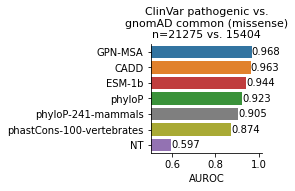

In [17]:
barplot(
    results_clinvar[results_clinvar.Model.isin(dataset_models["ClinVar"])].replace(models[0], "GPN-MSA"),
    "AUROC",
    clinvar_title,
    figsize=(2,2),
    #save_path="clinvar_auroc.svg",
)

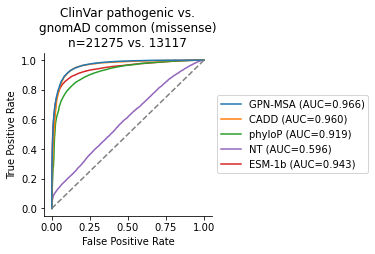

In [19]:
plot_curve(
    V_clinvar,
    results_clinvar[results_clinvar.Model.isin([
        "GPN-MSA", "CADD", "phyloP", "NT", "ESM-1b",
    ])],
    "ROC",
    title,
    #save_path="clinvar_roc.svg",
)

### Stratifying by conservation

In [37]:
log_pval_thresh = -np.log10(0.05)  # 1.3
V_clinvar["conservation"] = "neutral"
V_clinvar.loc[V_clinvar.phyloP < -log_pval_thresh, "conservation"] = "conserved"
V_clinvar.loc[V_clinvar.phyloP > log_pval_thresh, "conservation"] = "accelerated"
V_clinvar.conservation.value_counts()

conservation
conserved      24890
neutral         9974
accelerated     1815
Name: count, dtype: int64

In [38]:
rows = []
for c in V_clinvar.conservation.unique():
    V_c = V_clinvar[V_clinvar.conservation==c]
    for m in dataset_models["ClinVar"]:
        AUROC = roc_auc_score(V_c.label=="Pathogenic", -V_c[m])
        AUPRC = average_precision_score(V_c.label=="Pathogenic", -V_c[m])
        rows.append([c, m, AUROC, AUPRC])
results_clinvar_strat = pd.DataFrame(rows, columns=["Conservation", "Model", "AUROC", "AUPRC"])
results_clinvar_strat

,Conservation,Model,AUROC,AUPRC
0,neutral,multiz100way/89/128/64/True/defined.phastCons....,0.918516,0.760613
1,neutral,CADD,0.897630,0.693334
2,neutral,phyloP,0.667646,0.227345
3,neutral,phyloP-241-mammals,0.644568,0.279631
4,neutral,phastCons-100-vertebrates,0.773005,0.363481
5,neutral,ESM-1b,0.881874,0.738660
6,neutral,NT,0.572195,0.172020
7,conserved,multiz100way/89/128/64/True/defined.phastCons....,0.939847,0.982385
8,conserved,CADD,0.931172,0.976797
9,conserved,phyloP,0.865205,0.957730


In [39]:
def get_subtitle(c):
    n_pos, n_neg = V_clinvar[V_clinvar.conservation==c].label.value_counts()[["Pathogenic", "Common"]].values
    return f"{c} (n={n_pos} vs. {n_neg})"

results_clinvar_strat["subtitle"] = results_clinvar_strat.Conservation.apply(get_subtitle)
results_clinvar_strat

,Conservation,Model,AUROC,AUPRC,subtitle
0,neutral,multiz100way/89/128/64/True/defined.phastCons....,0.918516,0.760613,neutral (n=1371 vs. 8603)
1,neutral,CADD,0.897630,0.693334,neutral (n=1371 vs. 8603)
2,neutral,phyloP,0.667646,0.227345,neutral (n=1371 vs. 8603)
3,neutral,phyloP-241-mammals,0.644568,0.279631,neutral (n=1371 vs. 8603)
4,neutral,phastCons-100-vertebrates,0.773005,0.363481,neutral (n=1371 vs. 8603)
5,neutral,ESM-1b,0.881874,0.738660,neutral (n=1371 vs. 8603)
6,neutral,NT,0.572195,0.172020,neutral (n=1371 vs. 8603)
7,conserved,multiz100way/89/128/64/True/defined.phastCons....,0.939847,0.982385,conserved (n=19846 vs. 5044)
8,conserved,CADD,0.931172,0.976797,conserved (n=19846 vs. 5044)
9,conserved,phyloP,0.865205,0.957730,conserved (n=19846 vs. 5044)


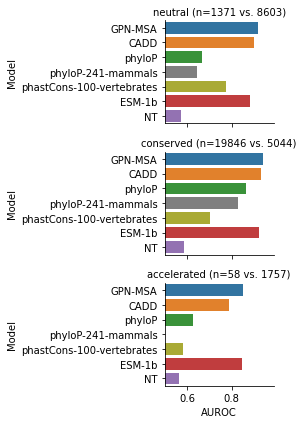

In [54]:
g = sns.catplot(
    data=results_clinvar_strat.replace(models[0], "GPN-MSA"),
    x="AUROC", y="Model", row="subtitle", palette=palette,
    kind="bar",
    height=2,
    aspect=2,
)
g.set_titles(row_template="{row_name}")
g.set(xlim=0.5);

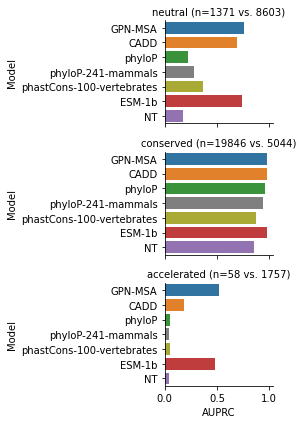

In [55]:
g = sns.catplot(
    data=results_clinvar_strat.replace(models[0], "GPN-MSA"),
    x="AUPRC", y="Model", row="subtitle", palette=palette,
    kind="bar",
    height=2,
    aspect=2,
)
g.set_titles(row_template="{row_name}");
#g.set(xlim=0.5);

## COSMIC frequent vs. gnomAD common (missense)

In [14]:
V_cosmic.dropna(subset=dataset_models["COSMIC"], inplace=True)
V_cosmic.label.value_counts()

label
Common      15404
Frequent      189
Name: count, dtype: int64

In [15]:
rows = []
for m in tqdm(dataset_models["COSMIC"]):
    y_true = V_cosmic.label=="Frequent"
    y_score = -V_cosmic[m]
    AUROC = roc_auc_score(y_true, y_score)
    AUPRC = average_precision_score(y_true, y_score)
    rows.append([m, AUROC, AUPRC])
results_cosmic = pd.DataFrame(rows, columns=["Model", "AUROC", "AUPRC"]).sort_values("AUPRC", ascending=False)
results_cosmic

100%|██████████| 7/7 [00:00<00:00, 62.43it/s]


,Model,AUROC,AUPRC
0,multiz100way/89/128/64/True/defined.phastCons....,0.765721,0.344098
6,ESM-1b,0.781012,0.208491
1,CADD,0.748640,0.161851
2,phyloP,0.679748,0.136975
3,phyloP-241-mammals,0.668605,0.086951
4,phastCons-100-vertebrates,0.664427,0.028828
5,NT,0.571142,0.016918


/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureW

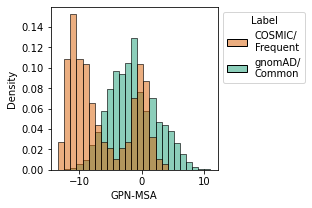

In [19]:
histplot_label(
    V_cosmic,
    hue_order=["COSMIC/\nFrequent", "gnomAD/\nCommon"],
    #save_path="hist_cosmic.svg",
)

In [18]:
n_pos, n_neg = (V_cosmic.label=="Frequent").sum(), (V_cosmic.label=="Common").sum()
cosmic_title = f"COSMIC frequent vs. \ngnomAD common (missense) \n n = {n_pos} vs. {n_neg}"
cosmic_pos_prop = n_pos/(n_pos+n_neg)
cosmic_title

'COSMIC frequent vs. \ngnomAD common (missense) \n n = 189 vs. 15404'

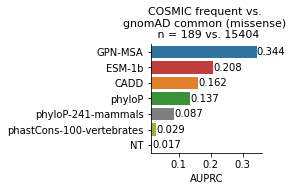

In [20]:
barplot(
    results_cosmic.replace(models[0], "GPN-MSA"),
    "AUPRC",
    cosmic_title,
    pos_prop=cosmic_pos_prop,
    figsize=(2,2),
    #save_path="cosmic_auprc.svg",
)

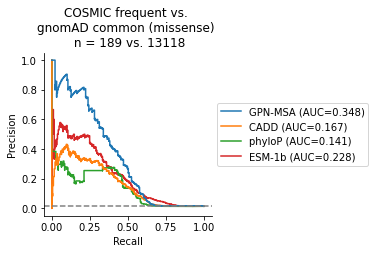

In [28]:
plot_curve(
    V_cosmic,
    results_cosmic[results_cosmic.Model.isin([
        "GPN-MSA", "CADD", "phyloP", "ESM-1b",
    ])],
    "PR",
    title,
    pos_label="Frequent",
    pos_prop=pos_prop,
    save_path="cosmic_pr_curve.svg",
)

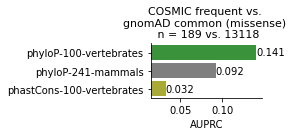

In [32]:
barplot(
    results_cosmic[results_cosmic.Model.isin([
         "phyloP", "phyloP-241-mammals", "phastCons-100-vertebrates",
    ])].replace("phyloP", "phyloP-100-vertebrates"),
    "AUPRC",
    cosmic_title,
    pos_prop=cosmic_pos_prop,
    figsize=(2,2*1/2),
    #save_path="cosmic_auprc_conservation.svg",
)

## OMIM pathogenic vs. gnomAD common (regulatory)

In [21]:
def get_subtitle(c, n_pathogenic, n_common):
    return f"{c}\nn={n_pathogenic} vs. {n_common}"

pos_prop = []

consequence_models = dataset_models["OMIM"]

rows = []
for c in tqdm(consequence_models):
    V_c = V_omim.copy() if c=="all" else V_omim[V_omim.consequence==c].copy()
    V_c.dropna(subset=consequence_models[c], inplace=True)
    
    n_pos, n_neg = (V_c.label=="Pathogenic").sum(), (V_c.label=="Common").sum()
    subtitle = get_subtitle(c, n_pos, n_neg)
    pos_prop.append(n_pos/(n_pos+n_neg))
    
    for m in consequence_models[c]:
        AUROC = roc_auc_score(V_c.label=="Pathogenic", -V_c[m])
        AUPRC = average_precision_score(V_c.label=="Pathogenic", -V_c[m])
        rows.append([m, c, AUROC, AUPRC, subtitle])
results_omim = pd.DataFrame(rows, columns=["Model", "Consequence", "AUROC", "AUPRC", "subtitle"])
results_omim

100%|██████████| 6/6 [00:01<00:00,  3.64it/s]


,Model,Consequence,AUROC,AUPRC,subtitle
0,multiz100way/89/128/64/True/defined.phastCons....,all,0.919022,0.243184,all\nn=406 vs. 212671
1,CADD,all,0.923727,0.172678,all\nn=406 vs. 212671
2,phyloP,all,0.860959,0.096405,all\nn=406 vs. 212671
3,phyloP-241-mammals,all,0.872706,0.088877,all\nn=406 vs. 212671
4,phastCons-100-vertebrates,all,0.832518,0.027026,all\nn=406 vs. 212671
5,NT,all,0.523451,0.001842,all\nn=406 vs. 212671
6,multiz100way/89/128/64/True/defined.phastCons....,Promoter,0.933938,0.299948,Promoter\nn=130 vs. 49565
7,CADD,Promoter,0.918330,0.166515,Promoter\nn=130 vs. 49565
8,phyloP,Promoter,0.884943,0.158674,Promoter\nn=130 vs. 49565
9,phyloP-241-mammals,Promoter,0.898187,0.222452,Promoter\nn=130 vs. 49565


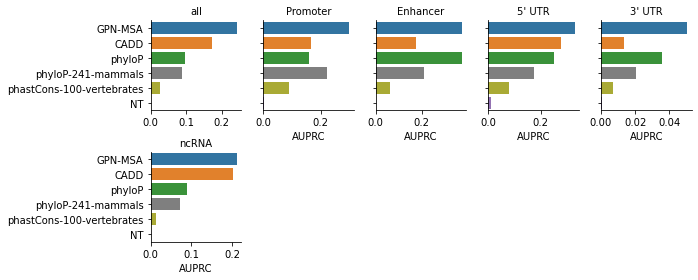

In [22]:
g = sns.catplot(
    data=results_omim.replace(models[0], "GPN-MSA"),
    y="Model",
    x="AUPRC",
    col="Consequence",
    height=2,
    #aspect=1.0,
    kind="bar",
    col_wrap=5,
    sharex=False,
    #sharey=True,
    #legend=False,
    palette=palette,
)
for ax in g.axes.flat:
    ax.set_ylabel("")
g.set_titles(col_template="{col_name}", row_template="{row_name}");
#g.set(xlim=0.5);

/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureW

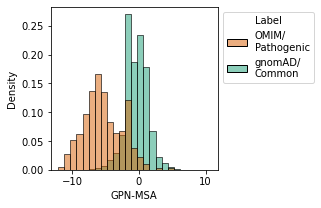

In [55]:
histplot_label(
    V_omim_all,
    hue_order=["OMIM/\nPathogenic", "gnomAD/\nCommon"],
    #save_path="hist_omim.svg",
)

In [18]:
replacements = {"Promoter": "promoter", "Enhancer": "enhancer"}

for key, value in replacements.items():
    results_omim['subtitle'] = results_omim['subtitle'].str.replace(key, value)

In [38]:
def omim_plot(
    df,
    save_path=None,
    title="OMIM pathogenic vs. gnomAD common (regulatory)",
    x=None,
    y=1.03,
):
    g = sns.catplot(
        data=df,
        y="Model",
        x="AUPRC",
        col="subtitle",
        height=1.5,
        aspect=1.0,
        kind="bar",
        col_wrap=3,
        sharex=False,
        sharey=True,
        legend=False,
        palette=palette,
    )
    g.set_titles(col_template="{col_name}", row_template="{row_name}");
    for i, ax in enumerate(g.axes):
        ax.set_xlim(left=pos_prop[i])
        ax.set_ylabel("")
    g.fig.suptitle(title, y=y, fontsize=12, x=x)
    g.figure.subplots_adjust(wspace=1.0, hspace=1.0)

    for ax in g.axes.flat:
        for bar in ax.patches:
            ax.text(
                bar.get_width(),  # X position, here at the end of the bar
                bar.get_y() + bar.get_height()/2,  # Y position, in the middle of the bar
                f'{bar.get_width():.3f}',  # Text to be displayed, formatted to 3 decimal places
                va='center'  # Vertical alignment
            )
    
    """
    # Get current x-tick labels
    catplot = g
    current_labels = [item.get_text() for item in catplot.ax.get_xticklabels()]

    # Convert to float and format with desired number of significant figures
    n_significant_figures = 2
    formatted_labels = [f"{float(label):.{n_significant_figures}g}" if label.replace('.','',1).isdigit() else label for label in current_labels]

    # Set new labels
    catplot.set_xticklabels(formatted_labels)
    """

    if save_path is not None:
        plt.savefig(plot_dir + save_path, bbox_inches="tight")

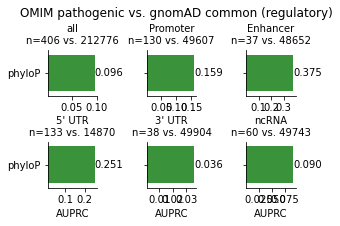

In [39]:
omim_plot(
    results_omim[results_omim.Model.isin([
        "GPN-MSA", "CADD", "phyloP", "NT",
    ])],
    x=0.6,
    #save_path="omim_auprc.svg",
)

In [37]:
title = "OMIM pathogenic vs.\ngnomAD common (regulatory)" + "\n" + results_omim[results_omim.Consequence=="all"].subtitle.iloc[0]

In [38]:
def omim_curve_plot(
    subset_models,
    save_path=None,
    title="OMIM pathogenic vs. gnomAD common (regulatory)",
    x=None,
    y=1.03,
):
    consequence_models = dataset_models["OMIM"]
    plot_f = PrecisionRecallDisplay
    metric = "AUPRC"
    xlabel = 'Recall'
    ylabel = 'Precision'
    pos_label = "Pathogenic"

    fig, axes = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(10, 5))
    
    rows = []
    i = 0
    for c in consequence_models:
        ax = axes.flat[i]
        V_c = V_omim.copy() if c=="all" else V_omim[V_omim[c]].copy()
        V_c.dropna(subset=consequence_models[c], inplace=True)

        n_pos, n_neg = (V_c.label=="Pathogenic").sum(), (V_c.label=="Common").sum()
        pos_prop = n_pos/(n_pos+n_neg)
        subtitle = get_subtitle(c, n_pos, n_neg)

        for m in np.array(consequence_models[c])[::-1]:
            if m not in subset_models: continue
            AUC = average_precision_score(V_c.label=="Pathogenic", -V_c[m])
            plot_f.from_predictions(V_c.label==pos_label, -V_c[m], name=m, ax=ax, label=f"{m}\n(AUC={AUC:.3f})", color=palette[m])

        ax.axhline(y=pos_prop, linestyle="--", color="gray")
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        sns.despine()

        ax.legend();
        # get handles and labels
        handles, labels = ax.get_legend_handles_labels()
        # reverse the order
        handles, labels = handles[::-1], labels[::-1]
        # create the legend with the reversed order
        ax.legend(handles, labels)#, loc='center left', bbox_to_anchor=(1, 0.5))    

        ax.set_title(subtitle)
        i += 1
    
    fig.suptitle(title, y=y, fontsize=12, x=x)
    plt.subplots_adjust(hspace=0.5) 

    if save_path is not None:
        plt.savefig(plot_dir + save_path, bbox_inches="tight")

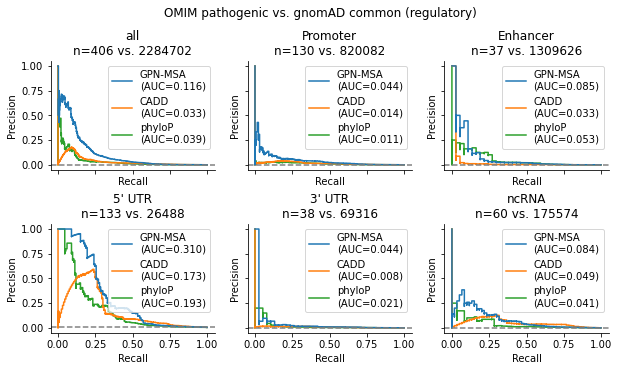

In [39]:
omim_curve_plot(
    subset_models=["GPN-MSA", "CADD", "phyloP"],
    save_path="omim_pr_curves.svg",
)

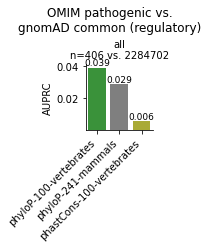

In [57]:
omim_plot(
    results_omim[(results_omim.Consequence=="all") & results_omim.Model.isin([
         "phyloP", "phyloP-241-mammals", "phastCons-100-vertebrates",
    ])].replace("phyloP", "phyloP-100-vertebrates"),
    title="OMIM pathogenic vs.\ngnomAD common (regulatory)",
    x=0.2, y=1.15,
    #save_path="omim_auprc_conservation.svg",
)

## gnomAD rare vs. common

In [23]:
V_gnomad.label = V_gnomad.label == "Rare"

### Classification metrics

In [24]:
consequence_models = dataset_models["gnomAD"]

rows = []
for c in tqdm(list(consequence_models.keys())):  
    if c == "all":
        df_c = V_gnomad
    else:
        df_c = V_gnomad[V_gnomad.consequence==c]
        
    df_c = df_c.dropna(subset=consequence_models[c])
    df_c = df_c.groupby("label").sample(n=df_c.label.value_counts().min(), random_state=42)
    print(c, df_c.label.value_counts())

    for m in consequence_models[c]:
        auroc = roc_auc_score(df_c.label, -df_c[m])
        rows.append([m, c, auroc])
results_gnomad2 = pd.DataFrame(rows, columns=["Model", "Consequence", "AUROC"])
results_gnomad2

  0%|          | 0/10 [00:00<?, ?it/s]

all label
False    349410
True     349410
Name: count, dtype: int64


 30%|███       | 3/10 [00:01<00:02,  2.35it/s]

missense label
False    15404
True     15404
Name: count, dtype: int64
synonymous label
False    18956
True     18956
Name: count, dtype: int64


 40%|████      | 4/10 [00:01<00:01,  3.34it/s]

5_prime_UTR label
False    14868
True     14868
Name: count, dtype: int64
3_prime_UTR label
False    49897
True     49897
Name: count, dtype: int64


 60%|██████    | 6/10 [00:02<00:01,  3.87it/s]

upstream_gene label
False    49565
True     49565
Name: count, dtype: int64


 70%|███████   | 7/10 [00:02<00:00,  4.06it/s]

downstream_gene label
False    49625
True     49625
Name: count, dtype: int64


 80%|████████  | 8/10 [00:02<00:00,  4.51it/s]

intron label
False    29855
True     29855
Name: count, dtype: int64
intergenic label
False    48497
True     48497
Name: count, dtype: int64


100%|██████████| 10/10 [00:03<00:00,  3.21it/s]

non_coding_transcript_exon label
False    49721
True     49721
Name: count, dtype: int64


,Model,Consequence,AUROC
0,multiz100way/89/128/64/True/defined.phastCons....,all,0.682392
1,CADD,all,0.583868
2,phyloP,all,0.621049
3,phyloP-241-mammals,all,0.614066
4,phastCons-100-vertebrates,all,0.558614
...,...,...,...
57,CADD,non_coding_transcript_exon,0.566118
58,phyloP,non_coding_transcript_exon,0.594488
59,phyloP-241-mammals,non_coding_transcript_exon,0.596590
60,phastCons-100-vertebrates,non_coding_transcript_exon,0.533282


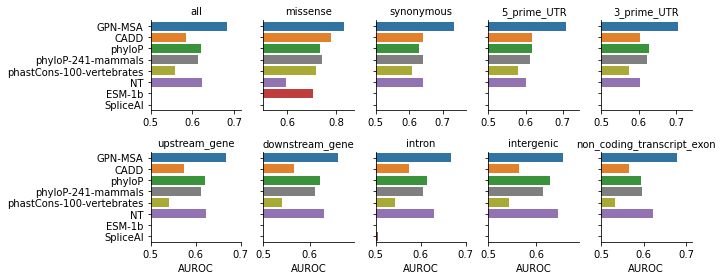

In [25]:
g = sns.catplot(
    data=results_gnomad2.replace(models[0], "GPN-MSA"),
    y="Model",
    x="AUROC",
    col="Consequence",
    height=2,
    #aspect=1.0,
    kind="bar",
    col_wrap=5,
    sharex=False,
    #sharey=True,
    #legend=False,
    palette=palette,
)
for ax in g.axes.flat:
    ax.set_ylabel("")
g.set_titles(col_template="{col_name}", row_template="{row_name}");
g.set(xlim=0.5);

### Stratifying by conservation

In [26]:
df = V_gnomad.dropna(subset=dataset_models["gnomAD"]["all"])
df.shape

(699117, 18)

In [27]:
log_pval_thresh = -np.log10(0.05)  # 1.3
df["conservation"] = "neutral"
df.loc[df.phyloP < -log_pval_thresh, "conservation"] = "conserved"
df.loc[df.phyloP > log_pval_thresh, "conservation"] = "accelerated"
df.conservation.value_counts()

conservation
neutral        550276
accelerated     86804
conserved       62037
Name: count, dtype: int64

In [28]:
rows = []
for c in df.conservation.unique():
    V_c = df[df.conservation==c]
    print(c, V_c.label.value_counts())
    for m in dataset_models["gnomAD"]["all"]:
        AUROC = roc_auc_score(V_c.label, -V_c[m])
        AUPRC = average_precision_score(V_c.label, -V_c[m])
        rows.append([c, m, AUROC, AUPRC])
results_gnomad_strat = pd.DataFrame(rows, columns=["Conservation", "Model", "AUROC", "AUPRC"])
results_gnomad_strat

accelerated label
False    60999
True     25805
Name: count, dtype: int64
neutral label
True     283051
False    267225
Name: count, dtype: int64
conserved label
True     40851
False    21186
Name: count, dtype: int64


,Conservation,Model,AUROC,AUPRC
0,accelerated,multiz100way/89/128/64/True/defined.phastCons....,0.642380,0.397658
1,accelerated,CADD,0.440817,0.276910
2,accelerated,phyloP,0.554363,0.334847
3,accelerated,phyloP-241-mammals,0.577681,0.367686
4,accelerated,phastCons-100-vertebrates,0.435768,0.279541
5,accelerated,NT,0.628689,0.381148
6,neutral,multiz100way/89/128/64/True/defined.phastCons....,0.662062,0.630377
7,neutral,CADD,0.542492,0.552984
8,neutral,phyloP,0.579666,0.572036
9,neutral,phyloP-241-mammals,0.575167,0.568120


In [29]:
def get_subtitle(c):
    labels = df[df.conservation==c].label
    n_pos, n_neg = labels.sum(), (~labels).sum()
    return f"{c} (n={n_pos} vs. {n_neg})"

results_gnomad_strat["subtitle"] = results_gnomad_strat.Conservation.apply(get_subtitle)
results_gnomad_strat

,Conservation,Model,AUROC,AUPRC,subtitle
0,accelerated,multiz100way/89/128/64/True/defined.phastCons....,0.642380,0.397658,accelerated (n=25805 vs. 60999)
1,accelerated,CADD,0.440817,0.276910,accelerated (n=25805 vs. 60999)
2,accelerated,phyloP,0.554363,0.334847,accelerated (n=25805 vs. 60999)
3,accelerated,phyloP-241-mammals,0.577681,0.367686,accelerated (n=25805 vs. 60999)
4,accelerated,phastCons-100-vertebrates,0.435768,0.279541,accelerated (n=25805 vs. 60999)
5,accelerated,NT,0.628689,0.381148,accelerated (n=25805 vs. 60999)
6,neutral,multiz100way/89/128/64/True/defined.phastCons....,0.662062,0.630377,neutral (n=283051 vs. 267225)
7,neutral,CADD,0.542492,0.552984,neutral (n=283051 vs. 267225)
8,neutral,phyloP,0.579666,0.572036,neutral (n=283051 vs. 267225)
9,neutral,phyloP-241-mammals,0.575167,0.568120,neutral (n=283051 vs. 267225)


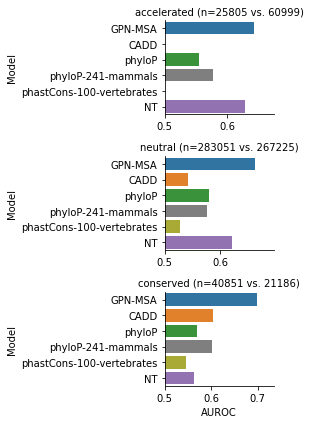

In [30]:
g = sns.catplot(
    data=results_gnomad_strat.replace(models[0], "GPN-MSA"),
    x="AUROC", y="Model", row="subtitle", palette=palette,
    kind="bar",
    height=2,
    aspect=2,
    sharex=False,
)
g.set_titles(row_template="{row_name}")
g.set(xlim=0.5);

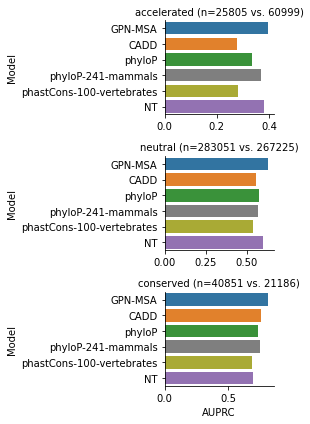

In [31]:
# TODO: set xlim to pos_prop
g = sns.catplot(
    data=results_gnomad_strat.replace(models[0], "GPN-MSA"),
    x="AUPRC", y="Model", row="subtitle", palette=palette,
    kind="bar",
    height=2,
    aspect=2,
    sharex=False,
)
g.set_titles(row_template="{row_name}");
#g.set(xlim=0.5);

In [15]:
#V_gnomad = V[V.source == "gnomAD"].copy()
#V_gnomad.label.value_counts()

In [16]:
# Drop 32 variants with MAF 1/n but AF > 0.5
# In the case of GPN-MSA and other LLR-based methods, it would be easy
# to include these variants in the analysis by "folding" (considering the major as the reference)
# (flipping the scores when AF > 0.5)
# but CADD and phyloP are only computed assuming a fixed ref
#V_gnomad = V_gnomad[V_gnomad.AC != V_gnomad.AN - 1].copy()
#V_gnomad.label.value_counts()

In [24]:
def get_subtitle(consequence, n_rare, n_common):
    c = consequence.replace("_variant", "")
    return f"{c}\nn={n_rare} vs. {n_common}"

def compute_odds_ratio(df, threshold_quantile, model_name):
    df = df.copy()
    threshold = df[model_name].quantile(threshold_quantile)
    if threshold == df[model_name].max():  # happens with SpliceAI
        print("WARNING: threshold == max(score)", threshold_quantile, model_name)
        return None, None, None, None, None, None
    df.loc[df[model_name] <= threshold, "ModelScoreTier"] = "Low" 
    df.loc[df[model_name] > threshold, "ModelScoreTier"] = "High"
    df = df[df.ModelScoreTier.isin(["Low", "High"])]
    df.ModelScoreTier = df.ModelScoreTier.astype('category')
    odds_ratio, p_value, min_counts, ci_lower, ci_upper = _compute_odds_ratio(df)
    return odds_ratio, p_value, min_counts, ci_lower, ci_upper, threshold

def _compute_odds_ratio(df):
    group_counts = df.groupby(["label", "ModelScoreTier"]).size()
    log_odds_se = sqrt(sum(1/group_counts)) # "All of statistics" eq. 15.7
    group_counts2 = group_counts.copy()
    #print(group_counts2)
    group_counts = group_counts.loc[pd.MultiIndex.from_tuples(
        [['Common', 'High'],
         ['Common', 'Low'],
         ['Rare', 'High'],
         ['Rare', 'Low']]
    )].values.reshape((2,2))
    min_counts = group_counts.min()
    odds_ratio, p_value = fisher_exact(group_counts, alternative='greater')
    log_odds_ratio = np.log(odds_ratio)
    ci_lower = np.exp(log_odds_ratio-2*log_odds_se)
    ci_upper = np.exp(log_odds_ratio+2*log_odds_se)
    # [ci_lower, ci_upper] is 95% CI
    #if np.isinf(odds_ratio):
    #    print(odds_ratio, p_value, group_counts2)
    return odds_ratio, p_value, min_counts, ci_lower, ci_upper

In [25]:
threshold_quantiles = np.logspace(-5, -1, 21)
#threshold_quantiles = np.logspace(-2, 0, 11)[:-1]

consequence_models = dataset_models["gnomAD"]

rows = []
for c in list(consequence_models.keys()):
    #if c != "missense": continue  # temporary
    #if c != "all": continue  # temporary
    if c not in ["missense", "synonymous", "5_prime_UTR", "3_prime_UTR"]: continue
    
    print(c)
    if c == "all":
        df_c = V_gnomad
    else:
        df_c = V_gnomad[V_gnomad.consequence.str.contains(c)]
        # optional filter
        if c != "missense": df_c = df_c[~df_c.consequence.str.contains("missense")]
        
    df_c = df_c.dropna(subset=consequence_models[c])
    
    if c == "all":
        #df_c.to_parquet("subset_4_gnomad_vs_gnomad.parquet", index=False)
        #print(len(df_c))
        V_gnomad_all = df_c
        #raise Exception("debug")
    # optional subsample
    #df_c = df_c.groupby("label").sample(n=df_c.label.value_counts().min(), random_state=42).sample(frac=1, random_state=42)
    
    for m in tqdm(consequence_models[c]):
        subtitle = get_subtitle(c, (df_c.label=="Rare").sum(), (df_c.label=="Common").sum())
        for tq in threshold_quantiles:
            if m in ablation_models[1:] and tq != 1e-3: continue
            OR, p_value, min_counts, cil, ciu, threshold = compute_odds_ratio(df_c[[m, "label"]], tq, m)
            rows.append([m, c, tq, OR, p_value, min_counts, cil, ciu, threshold, subtitle])
results_gnomad = pd.DataFrame(rows, columns=["Model", "Consequence", "Quantile threshold", "Odds ratio", "p_value", "min_counts", "cil", "ciu", "Threshold", "subtitle"])
results_gnomad

missense


100%|██████████| 8/8 [00:03<00:00,  2.07it/s]


,Model,Consequence,Quantile threshold,Odds ratio,p_value,min_counts,cil,ciu,Threshold,subtitle
0,multiz100way/89/128/64/True/defined.phastCons....,missense,0.000010,inf,7.470884e-01,0,NaN,inf,-13.428020,missense\nn=35409 vs. 11987
1,multiz100way/89/128/64/True/defined.phastCons....,missense,0.000016,inf,7.470884e-01,0,NaN,inf,-13.404197,missense\nn=35409 vs. 11987
2,multiz100way/89/128/64/True/defined.phastCons....,missense,0.000025,inf,5.581370e-01,0,NaN,inf,-13.372394,missense\nn=35409 vs. 11987
3,multiz100way/89/128/64/True/defined.phastCons....,missense,0.000040,inf,5.581370e-01,0,NaN,inf,-13.334314,missense\nn=35409 vs. 11987
4,multiz100way/89/128/64/True/defined.phastCons....,missense,0.000063,inf,4.169717e-01,0,NaN,inf,-13.219798,missense\nn=35409 vs. 11987
...,...,...,...,...,...,...,...,...,...,...
163,PrimateAI-3D,missense,0.015849,23.270650,6.892982e-78,11,12.671319,42.736133,-0.929089,missense\nn=35409 vs. 11987
164,PrimateAI-3D,missense,0.025119,24.145878,7.953997e-124,17,14.806728,39.375573,-0.910348,missense\nn=35409 vs. 11987
165,PrimateAI-3D,missense,0.039811,23.665937,1.000103e-195,28,16.161651,34.654662,-0.886495,missense\nn=35409 vs. 11987
166,PrimateAI-3D,missense,0.063096,22.546970,2.925791e-309,48,16.840635,30.186859,-0.853952,missense\nn=35409 vs. 11987


/tmp/ipykernel_2801289/2596275445.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V["Label"] = V.source + "/\n" + V.label
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaf

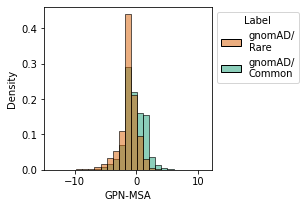

In [ ]:
histplot_label(
    V_gnomad_all,
    hue_order=["gnomAD/\nRare", "gnomAD/\nCommon"],
    #save_path="hist_gnomad.svg",
)

(0.0, 0.007)

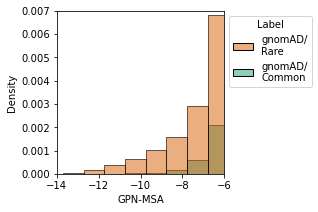

In [116]:
histplot_label(
    V_gnomad_all,
    hue_order=["gnomAD/\nRare", "gnomAD/\nCommon"],
)
plt.xlim(-14, -6)
plt.ylim(0, 7e-3)
#plt.savefig(plot_dir + "hist_gnomad_zoom.svg", bbox_inches="tight")

In [41]:
print("Careful if inf, should handle separately: ", results_gnomad["Odds ratio"].max())

Careful if inf, should handle separately:  89.25922147651006


In [26]:
limit_per_consequence = results_gnomad.query("min_counts < 10").groupby("Consequence")["Quantile threshold"].max()
limit_per_consequence

Consequence
missense    0.025119
Name: Quantile threshold, dtype: float64

In [27]:
def above_limit(r):
    try:
         l = limit_per_consequence[r.Consequence]
    except:
        return True
    return r["Quantile threshold"] > l

results_gnomad["above_limit"] = results_gnomad.apply(above_limit, axis=1)

In [28]:
results_gnomad[results_gnomad.above_limit].min_counts.min()

13

In [29]:
results_gnomad[results_gnomad.above_limit]["Quantile threshold"].min()

0.039810717055349734

In [30]:
replacements = {
    "5_prime_UTR": "5' UTR",
    "3_prime_UTR": "3' UTR",
    "upstream_gene": "upstream-of-gene",
    "downstream_gene": "downstream-of-gene",
    "non_coding_transcript_exon": "ncRNA",
}

for key, value in replacements.items():
    results_gnomad['subtitle'] = results_gnomad['subtitle'].str.replace(key, value)
    results_gnomad['Consequence'] = results_gnomad['Consequence'].str.replace(key, value)

In [31]:
x = results_gnomad.subtitle.drop_duplicates()
x = "``" + results_gnomad.Consequence.drop_duplicates() + "'': " + x.str.split('\n').str[-1].str.replace("n=", "$n=$ ")
x = ", ".join(x.values)
x

"``missense'': $n=$ 35409 vs. 11987"

In [32]:
def gnomad_plot(df, save_path=None, y=1.15, height=2.1):
    g = sns.relplot(
        data=df[(df.p_value<=0.05) & (df.above_limit)],
        x="Quantile threshold",
        y="Odds ratio",
        hue="Model",
        col="subtitle",
        #col="Consequence",
        height=height,
        kind="line",
        marker="o",
        col_wrap=min(5, len(df.subtitle.unique())),
        facet_kws={'sharey': False, 'sharex': False},
        palette=palette,
        markersize=5,
    )

    g.set_titles(col_template="{col_name}", row_template="{row_name}")
    g.set(xscale='log');
    #g.fig.subplots_adjust(top=1.0)
    g.fig.subplots_adjust(
        hspace=1.2,
        #wspace=0.5,
    ) # 1.0 # modification
    plt.suptitle("gnomAD rare vs. common", y=y);
    for ax in g.axes.flat:
        xticks = df[(df.p_value<=0.05) & (df.above_limit)]["Quantile threshold"].drop_duplicates().values
        xticks = xticks[::2]
        ax.set_xticks(xticks)
        ax.set_xticklabels([f"{x:.2e}" for x in xticks])

    #    ax.set_xticks([1e-4, 1e-3, 1e-2, 1e-1])
        ax.tick_params(axis='x', rotation=45)

    """
    for ax, subtitle in zip(g.axes.flat, g.col_names):
        ax.set_title(ax.get_title(), fontweight='bold')
        
        xticks = [1e-4, 1e-3, 1e-2, 1e-1]
        ax.set_xticks(xticks)
        left = results_gnomad[results_gnomad.above_limit]["Quantile threshold"].min() * 0.8
        right = results_gnomad[results_gnomad.above_limit]["Quantile threshold"].max() / 0.8
        ax.set_xlim(left=left, right=right)
        ax.set_xlabel("Quantile threshold")

        secax = ax.secondary_xaxis('top')
        secax.set_xscale('log')
        secax.set_xticks(xticks)
        subset_df = df[(df['Consequence'] == subtitle) & (df['Model'] == "GPN-MSA")]
        tick_labels = [
            subset_df[
                np.isclose(subset_df["Quantile threshold"], tq)
            ].Threshold.values[0]
            for tq in xticks
        ]
        tick_labels = [f"{x:.1f}" for x in tick_labels]
        secax.set_xticklabels(tick_labels)
        secax.set_xlabel("GPN-MSA score")
    """
  
    if save_path is not None:
        plt.savefig(plot_dir + save_path, bbox_inches="tight")

In [35]:
models[0]

'multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True'

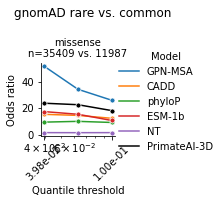

In [34]:
import warnings
warnings.filterwarnings('ignore')
gnomad_plot(
    results_gnomad[results_gnomad.Model.isin([
        models[0], "CADD", "phyloP", "ESM-1b", "SpliceAI", "NT", "PrimateAI-3D"
    ])].replace(models[0], "GPN-MSA"),
    y=1.13,
    #save_path="gnomad_or.svg",
    #save_path="gnomad_or_missense.pdf",
)

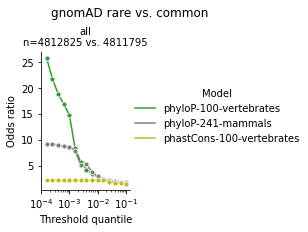

In [90]:
gnomad_plot(
    results_gnomad[(results_gnomad.Consequence=="all") & results_gnomad.Model.isin([
         "phyloP", "phyloP-241-mammals", "phastCons-100-vertebrates",
    ])].replace("phyloP", "phyloP-100-vertebrates"),
    y=1.25, height=2.5,
    #save_path="gnomad_or_conservation.svg",
)

## gnomAD Enformer set (low-frequency vs. common)

In [32]:
V_enformer.label = V_enformer.label == "Low-frequency"
V_enformer.label.value_counts()

label
False    100000
True     100000
Name: count, dtype: int64

### Classification metrics

In [33]:
consequence_models = dataset_models["gnomAD_Enformer"]

rows = []
for c in tqdm(list(consequence_models.keys())):  
    df_c = V_enformer[V_enformer.consequence==c]
        
    df_c = df_c.dropna(subset=consequence_models[c])
    df_c = df_c.groupby("label").sample(n=df_c.label.value_counts().min(), random_state=42)
    print(c, df_c.label.value_counts())

    for m in consequence_models[c]:
        auroc = roc_auc_score(df_c.label, -df_c[m])
        rows.append([m, c, auroc])
results_enformer2 = pd.DataFrame(rows, columns=["Model", "Consequence", "AUROC"])
results_enformer2

  0%|          | 0/2 [00:00<?, ?it/s]

upstream_gene label
False    49649
True     49649
Name: count, dtype: int64


100%|██████████| 2/2 [00:00<00:00,  3.04it/s]

intergenic label
False    48737
True     48737
Name: count, dtype: int64


,Model,Consequence,AUROC
0,multiz100way/89/128/64/True/defined.phastCons....,upstream_gene,0.585556
1,CADD,upstream_gene,0.490452
2,phyloP,upstream_gene,0.564918
3,phyloP-241-mammals,upstream_gene,0.552968
4,phastCons-100-vertebrates,upstream_gene,0.522353
5,NT,upstream_gene,0.560211
6,Enformer_l1,upstream_gene,0.514043
7,Enformer_l2,upstream_gene,0.513359
8,Enformer_linf,upstream_gene,0.510934
9,multiz100way/89/128/64/True/defined.phastCons....,intergenic,0.571834


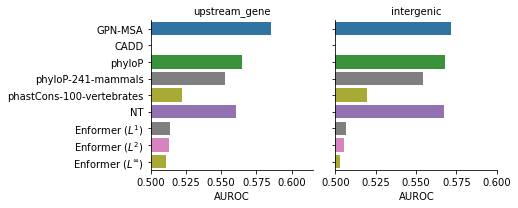

In [34]:
g = sns.catplot(
    data=results_enformer2.replace({
        models[0]: "GPN-MSA",
        "Enformer_l1": r"Enformer ($L^1$)",
        "Enformer_l2": r"Enformer ($L^2$)",
        "Enformer_linf": r"Enformer ($L^\infty$)",
    }),
    y="Model",
    x="AUROC",
    col="Consequence",
    height=3,
    #aspect=1.0,
    kind="bar",
    col_wrap=5,
    sharex=False,
    #sharey=True,
    #legend=False,
    palette=palette,
)
for ax in g.axes.flat:
    ax.set_ylabel("")
g.set_titles(col_template="{col_name}", row_template="{row_name}");
g.set(xlim=0.5);

In [166]:
threshold_quantiles = np.logspace(-5, -1, 21)

rows = []

df_c = V_enformer.dropna(subset=models_enformer)

for m in tqdm(models_enformer):
    for tq in threshold_quantiles:
        OR, p_value, min_counts, cil, ciu, threshold = compute_odds_ratio(df_c[[m, "label"]], tq, m)
        rows.append([m, tq, OR, p_value, min_counts, cil, ciu, threshold])
results_enformer = pd.DataFrame(rows, columns=["Model", "Quantile threshold", "Odds ratio", "p_value", "min_counts", "cil", "ciu", "Threshold"])
results_enformer

100%|██████████| 8/8 [08:00<00:00, 60.03s/it]


,Model,Quantile threshold,Odds ratio,p_value,min_counts,cil,ciu,Threshold
0,multiz100way/89/128/64/True/defined.phastCons....,0.000010,4.581095,7.919088e-07,9,2.229671,9.412345,-9.988813
1,multiz100way/89/128/64/True/defined.phastCons....,0.000016,4.635664,4.460667e-10,14,2.603645,8.253576,-9.594156
2,multiz100way/89/128/64/True/defined.phastCons....,0.000025,4.481585,8.118485e-15,23,2.854272,7.036682,-9.281250
3,multiz100way/89/128/64/True/defined.phastCons....,0.000040,3.369524,9.314497e-17,46,2.430696,4.670964,-8.995733
4,multiz100way/89/128/64/True/defined.phastCons....,0.000063,2.923843,2.606757e-21,82,2.281567,3.746923,-8.695312
...,...,...,...,...,...,...,...,...
163,Enformer_linf,0.015849,1.109611,6.151662e-58,40403,1.095242,1.124169,-0.101257
164,Enformer_linf,0.025119,1.089844,3.599367e-62,64691,1.078580,1.101224,-0.077393
165,Enformer_linf,0.039811,1.081657,2.896735e-80,103098,1.072710,1.090678,-0.058197
166,Enformer_linf,0.063096,1.071810,1.620383e-96,164331,1.064681,1.078987,-0.043030


In [167]:
n_pos, n_neg = (df_c.label=="Rare").sum(), (df_c.label=="Common").sum()
title = f"gnomAD low-frequency vs. common\n(upstream, downstream, intergenic)"  #\nn={n_pos} vs. {n_neg}"
title

'gnomAD low-frequency vs. common\n(upstream, downstream, intergenic)'

In [168]:
limit = results_enformer.query("min_counts < 10")["Quantile threshold"].max()
limit

9.999999999999999e-06

In [169]:
def above_limit(r):
    return np.isnan(limit) or r["Quantile threshold"] > limit + 1e-8

results_enformer["above_limit"] = results_enformer.apply(above_limit, axis=1)

In [182]:
def enformer_plot(df, save_path=None):
    plt.figure(figsize=(2,2))
    g = sns.lineplot(
        data=df[(df.p_value<=0.05) & (df.above_limit)],
        x="Quantile threshold",
        y="Odds ratio",
        hue="Model",
        marker="o",
        palette=palette,
        markersize=5,
    )
    #for ax in g.axes: ax.axhline(1, ls='--', color="grey")
    #g.set_titles(col_template="{col_name}", row_template="{row_name}")
    g.set(xscale='log');
    #g.fig.subplots_adjust(top=0.75)
    #plt.suptitle("gnomAD rare vs. common", y=0.9);
    sns.despine()
    #ax.set_ylim(bottom=pos_prop[i])
    plt.ylim(bottom=1)
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    #g.set_xticks([1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
    
    ax = g     
    xticks = [1e-4, 1e-3, 1e-2, 1e-1]
    ax.set_xticks(xticks)

    if "GPN-MSA" in df.Model.unique():
        secax = ax.secondary_xaxis('top')
        secax.set_xscale('log')
        secax.set_xticks(xticks)
        subset_df = df[(df['Model'] == "GPN-MSA")]
        tick_labels = [
            subset_df[
                np.isclose(subset_df["Quantile threshold"], tq)
            ].Threshold.values[0]
            for tq in xticks
        ]
        tick_labels = [f"{x:.1f}" for x in tick_labels]
        secax.set_xticklabels(tick_labels)
        secax.set_xlabel("GPN-MSA score")

    plt.title(title, fontsize=11);
    if save_path is not None:
        plt.savefig(plot_dir + save_path, bbox_inches="tight")

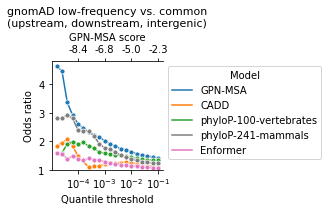

In [186]:
enformer_plot(
    results_enformer[results_enformer.Model.isin([
        models[0], "CADD", "phyloP", "Enformer_l1", "phyloP-241-mammals",
    ])].replace({"Enformer_l1": "Enformer", "phyloP": "phyloP-100-vertebrates", models[0]: "GPN-MSA"}),
    #save_path="gnomad_or_enformer.svg",
)

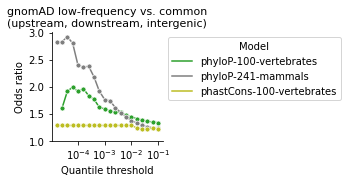

In [184]:
enformer_plot(
    results_enformer[results_enformer.Model.isin([
         "phyloP", "phyloP-241-mammals", "phastCons-100-vertebrates",
    ])].replace("phyloP", "phyloP-100-vertebrates"),
    #save_path="gnomad_or_enformer_conservation.svg",
)

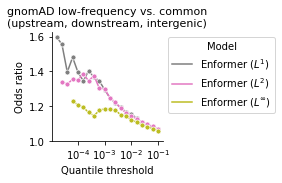

In [185]:
enformer_plot(
    results_enformer[results_enformer.Model.isin([
        "Enformer_l1", "Enformer_l2", "Enformer_linf",
    ])].replace({
        "Enformer_l1": r"Enformer ($L^1$)",
        "Enformer_l2": r"Enformer ($L^2$)",
        "Enformer_linf": r"Enformer ($L^\infty$)",
    }),
    #save_path="gnomad_or_enformer_norms.pdf",
)

## Ablation study

In [106]:
results_gwas_ablation = results_gwas[
    results_gwas.Model.str.contains("LogisticRegression") &
    results_gwas.Model.str.contains("multiz")
]
results_gwas_ablation = results_gwas_ablation.groupby("Model").AUROC.mean().to_frame().reset_index()
results_gwas_ablation.Model = results_gwas_ablation.Model.str.replace(".LogisticRegression", "")
results_gwas_ablation

,Model,AUROC
0,multiz100way/89/128/64/True/defined.phastCons....,0.658057
1,multiz100way/89/128/64/True/defined.phastCons....,0.732561
2,multiz100way/89/128/64/True/defined.phastCons....,0.732494
3,multiz100way/89/128/64/True/defined.phastCons....,0.714560
4,multiz100way/89/128/64/True/defined.phastCons....,0.728183
5,multiz100way/89/128/64/True/defined.phastCons....,0.701242
6,multiz100way/89/128/64/True/defined.phastCons....,0.732140
7,multiz100way/89/128/64/True/defined.phastCons....,0.712122
8,multiz100way/89/128/64/True/defined.phastCons....,0.736330
9,multiz100way/89/128/64/True/defined.phastCons....,0.651094


In [147]:
results_ablation = [
    df[df.Model.isin(models[:1] + ablation_models)]
    for df in [
        results_clinvar[["Model", "AUROC"]].rename(columns={"AUROC": "ClinVar"}),
        results_cosmic[["Model", "AUPRC"]].rename(columns={"AUPRC": "COSMIC"}),
        results_omim[results_omim.Consequence=="all"][["Model", "AUPRC"]].rename(columns={"AUPRC": "OMIM"}),
        results_gnomad[
            (results_gnomad["Quantile threshold"]==1e-3) & (results_gnomad.Consequence=="all") 
        ][["Model", "Odds ratio"]].rename(columns={"Odds ratio": "gnomAD"}),
        results_gwas_ablation.rename(columns={"AUROC": "GWAS"}),
    ]
]

results_ablation = reduce(lambda x, y: x.merge(y, on="Model", how="left"), results_ablation)
results_ablation

,Model,ClinVar,COSMIC,OMIM,gnomAD,GWAS
0,multiz100way/89/256/128/True/defined.phastCons...,0.966573,0.357106,0.127410,36.659241,0.737470
1,multiz100way/89/128/64/True/defined.phastCons....,0.966367,0.334161,0.106964,37.105859,0.733894
2,multiz100way/89/256/128/True/defined.phastCons...,0.966203,0.368041,0.107375,37.328784,0.732380
3,multiz100way/89/256/128/True/defined.phastCons...,0.966161,0.350975,0.115069,37.874235,0.737503
4,multiz100way/89/128/64/True/defined.phastCons....,0.965993,0.348005,0.116074,38.350315,0.736330
5,multiz100way/89/128/64/True/defined.phastCons....,0.965903,0.342592,0.122366,35.517883,0.733602
6,multiz100way/89/128/64/True/defined.phastCons....,0.965504,0.325528,0.097476,35.949228,0.729384
7,multiz100way/89/128/64/True/defined.phastCons....,0.965352,0.334579,0.116613,34.462112,0.729037
8,multiz100way/89/128/64/True/defined.phastCons....,0.965173,0.342336,0.107573,36.987425,0.732140
9,multiz100way/89/128/64/True/defined.phastCons....,0.964764,0.303342,0.112456,34.056944,0.732652


In [148]:
hparam_name = {
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True": "Default",
    
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/False/True/True": "w/o MSA",
    "msa_multiz100way/89": "MSA frequency (no neural net)",
    
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.50_0.001/medium/0.1/[\d]+/30000/True/True/True": "Train on 50% most conserved",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_1.00_0.00/medium/0.1/[\d]+/30000/True/True/True": "Train on 100% of genome",
    
    r"multiz100way/99/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True": "Include closest primates",
    r"multiz100way_mammals/51/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True": "51 mammals",
    r"multiz100way_vertebrates/51/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True": "51 vertebrates",
    
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/False/True": "Don't upweight conserved",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/False": "Don't replace non-conserved",
    
    r"multiz100way/89/256/128/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True": "Window size = 256",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True.64": "Window size = 64",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True.32": "Window size = 32",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True.16": "Window size = 16",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True.8": "Window size = 8",
    r"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/[\d]+/30000/True/True/True.4": "Window size = 4",
}

In [149]:
results_ablation["Ablation"] = None
for k, v in hparam_name.items():
    results_ablation.loc[results_ablation.Model.str.match(k), "Ablation"] = v
results_ablation = results_ablation.dropna(subset="Ablation")
results_ablation.Ablation.value_counts()

Ablation
Window size = 256                3
Default                          3
Window size = 64                 3
Don't upweight conserved         3
Window size = 32                 3
Don't replace non-conserved      3
51 vertebrates                   3
51 mammals                       3
Window size = 16                 3
Train on 50% most conserved      3
Window size = 8                  3
Train on 100% of genome          3
Include closest primates         3
Window size = 4                  3
w/o MSA                          3
MSA frequency (no neural net)    1
Name: count, dtype: int64

In [150]:
results_ablation = results_ablation.groupby("Ablation")[["ClinVar", "COSMIC", "OMIM", "gnomAD", "GWAS"]].agg(["mean", "std"])
results_ablation.index.name = None
results_ablation = results_ablation.loc[hparam_name.values()]
results_ablation = results_ablation.round(3)
results_ablation

ClinVar        COSMIC          OMIM         \
                                 mean    std   mean    std   mean    std   
Default                         0.966  0.000  0.342  0.007  0.115  0.008   
w/o MSA                         0.582  0.001  0.014  0.000  0.000  0.000   
MSA frequency (no neural net)   0.947    NaN  0.266    NaN  0.030    NaN   
Train on 50% most conserved     0.960  0.001  0.237  0.020  0.122  0.012   
Train on 100% of genome         0.957  0.001  0.207  0.014  0.119  0.002   
Include closest primates        0.950  0.002  0.211  0.007  0.128  0.018   
51 mammals                      0.962  0.001  0.317  0.002  0.067  0.002   
51 vertebrates                  0.964  0.000  0.334  0.005  0.090  0.007   
Don't upweight conserved        0.964  0.000  0.297  0.006  0.122  0.016   
Don't replace non-conserved     0.964  0.000  0.328  0.006  0.102  0.002   
Window size = 256               0.966  0.000  0.359  0.009  0.117  0.010   
Window size = 64                0.965  0.000  0.334  0.008  0.107  0.010   
Window size = 32                0.964  0.000  0.317  0.006  0.107  0.014   
Window size = 16                0.962  0.000  0.242  0.003  0.094  0.009   
Window size = 8                 0.958  0.000  0.188  0.017  0.078  0.008   
Window size = 4                 0.938  0.001  0.134  0.020  0.049  0.002   

                               gnomAD          GWAS         
                                 mean    std   mean    std  
Default                        36.991  1.420  0.735  0.001  
w/o MSA                         1.933  0.029  0.654  0.004  
MSA frequency (no neural net)  17.344    NaN    NaN    NaN  
Train on 50% most conserved    28.690  1.102  0.732  0.002  
Train on 100% of genome        26.516  1.228  0.730  0.001  
Include closest primates       31.541  1.485  0.728  0.003  
51 mammals                     33.343  0.314  0.734  0.003  
51 vertebrates                 33.837  0.496  0.731  0.000  
Don't upweight conserved       34.162  1.032  0.732  0.000  
Don't replace non-conserved    33.122  1.685  0.733  0.001  
Window size = 256              37.287  0.609  0.736  0.003  
Window size = 64               35.800  1.269  0.730  0.002  
Window size = 32               34.945  0.612  0.726  0.003  
Window size = 16               28.581  0.691  0.717  0.003  
Window size = 8                23.325  0.349  0.712  0.000  
Window size = 4                10.182  0.298  0.702  0.001

In [153]:
categories = ["ClinVar", "COSMIC", "OMIM", "gnomAD", "GWAS"]
results_ablation_tex = pd.DataFrame()

def mean_std_str(mean, std):
    if pd.isna(mean):
        return "NA"
    elif pd.isna(std):
        return f"{mean:.3f}"
    else:
        return f"{mean:.3f} ± {std:.3f}"
    
def mean_str(mean, is_gnomad):
    if pd.isna(mean):
        return "NA"
    else:
        if is_gnomad:
            return f"{mean:.1f}"
        else:
            return f"{mean:.3f}"

for category in categories:
    mean_col = (category, "mean")
    std_col = (category, "std")
    
    results_ablation_tex[category] = results_ablation.apply(
        #lambda row: mean_std_str(row[mean_col], row[std_col]), axis=1
        lambda row: mean_str(row[mean_col], category=="gnomAD"), axis=1
    )
results_ablation_tex

,ClinVar,COSMIC,OMIM,gnomAD,GWAS
Default,0.966,0.342,0.115,37.0,0.735
w/o MSA,0.582,0.014,0.000,1.9,0.654
MSA frequency (no neural net),0.947,0.266,0.030,17.3,NA
Train on 50% most conserved,0.960,0.237,0.122,28.7,0.732
Train on 100% of genome,0.957,0.207,0.119,26.5,0.730
Include closest primates,0.950,0.211,0.128,31.5,0.728
51 mammals,0.962,0.317,0.067,33.3,0.734
51 vertebrates,0.964,0.334,0.090,33.8,0.731
Don't upweight conserved,0.964,0.297,0.122,34.2,0.732
Don't replace non-conserved,0.964,0.328,0.102,33.1,0.733


In [154]:
print(results_ablation_tex.to_latex(escape="latex"))

\begin{tabular}{llllll}
\toprule
 & ClinVar & COSMIC & OMIM & gnomAD & GWAS \\
\midrule
Default & 0.966 & 0.342 & 0.115 & 37.0 & 0.735 \\
w/o MSA & 0.582 & 0.014 & 0.000 & 1.9 & 0.654 \\
MSA frequency (no neural net) & 0.947 & 0.266 & 0.030 & 17.3 & NA \\
Train on 50\% most conserved & 0.960 & 0.237 & 0.122 & 28.7 & 0.732 \\
Train on 100\% of genome & 0.957 & 0.207 & 0.119 & 26.5 & 0.730 \\
Include closest primates & 0.950 & 0.211 & 0.128 & 31.5 & 0.728 \\
51 mammals & 0.962 & 0.317 & 0.067 & 33.3 & 0.734 \\
51 vertebrates & 0.964 & 0.334 & 0.090 & 33.8 & 0.731 \\
Don't upweight conserved & 0.964 & 0.297 & 0.122 & 34.2 & 0.732 \\
Don't replace non-conserved & 0.964 & 0.328 & 0.102 & 33.1 & 0.733 \\
Window size = 256 & 0.966 & 0.359 & 0.117 & 37.3 & 0.736 \\
Window size = 64 & 0.965 & 0.334 & 0.107 & 35.8 & 0.730 \\
Window size = 32 & 0.964 & 0.317 & 0.107 & 34.9 & 0.726 \\
Window size = 16 & 0.962 & 0.242 & 0.094 & 28.6 & 0.717 \\
Window size = 8 & 0.958 & 0.188 & 0.078 & 23.3 & 0.712 

In [207]:
results_ablation_tex[results_ablation_tex.index != "MSA frequency (no neural net)"].astype(float).corr(method="spearman")

,ClinVar,COSMIC,OMIM,gnomAD,GWAS
ClinVar,1.000000,0.955735,0.283918,0.931463,0.722453
COSMIC,0.955735,1.000000,0.254480,0.930234,0.785842
OMIM,0.283918,0.254480,1.000000,0.429339,0.443548
gnomAD,0.931463,0.930234,0.429339,1.000000,0.737032
GWAS,0.722453,0.785842,0.443548,0.737032,1.000000
